**Checking how long the coarse resolution runs take to spinup**

In [4]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

In [2]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))[:nfiles]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [3]:
def plot_diff_levtime(simulation,variable,ax,scale=None):
    initvar = simulation[variable].isel(Time=slice(0,400)).mean(["west_east","south_north"]).persist()
    endvar = simulation[variable].isel(Time=slice(-200,-1)).mean(["Time","west_east","south_north"])
    if scale:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units},cmap=plt.cm.RdBu_r,vmin=-scale,vmax=scale)
    else:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units})
    ax.set_title(simulation[variable].description + " anomaly relative to last 50 days")

In [4]:
def plot_diff_lattime_3d(simulation,variable,level,ax,scale = None):
    try :
        initvar = simulation[variable].sel(bottom_top=level).isel(Time=slice(0,400)).mean(["west_east"]).persist()
        endvar  = simulation[variable].sel(bottom_top=level).isel(Time=slice(-200,-1)).mean(["Time","west_east"])
    except ValueError:
        try :
            initvar = simulation[variable].sel(bottom_top=level).isel(Time=slice(0,400)).mean(["west_east_stag"]).persist()
            endvar  = simulation[variable].sel(bottom_top=level).isel(Time=slice(-200,-1)).mean(["Time","west_east_stag"])  
        except ValueError:
            initvar = simulation[variable].sel(bottom_top_stag=level).isel(Time=slice(0,400)).mean(["west_east"]).persist()
            endvar  = simulation[variable].sel(bottom_top_stag=level).isel(Time=slice(-200,-1)).mean(["Time","west_east"])
    if scale:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units},cmap=plt.cm.RdBu_r,vmin=-scale,vmax=scale)
    else:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units})
    ax.set_title(simulation[variable].description + " anomaly relative to last 50 days - level = %i hPa"%(plevs.sel(bottom_top=level)/100))

In [5]:
def plot_diff_lattime_2d(simulation,variable,ax,scale=None):
    initvar = simulation[variable].isel(Time=slice(0,400)).mean(["west_east"]).persist()
    endvar  = simulation[variable].isel(Time=slice(-200,-1)).mean(["Time","west_east"])
    if scale:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units},cmap=plt.cm.RdBu_r,vmin=-scale,vmax=scale)
    else:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units})
    ax.set_title(simulation[variable].description + " anomaly relative to last 50 days")
    
def plot_diff_lattime_2d_rain(simulation,variable,ax,scale=None):
    initvar = 4*simulation[variable].isel(Time=slice(0,400)).diff('Time').mean(["west_east"]).persist()
    endvar  = 4*simulation[variable].isel(Time=slice(-200,-1)).diff('Time').mean(["Time","west_east"])
    if scale:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units},cmap=plt.cm.RdBu_r,vmin=-scale,vmax=scale)
    else:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units})
    ax.set_title(simulation[variable].description + " anomaly relative to last 50 days")

# Hovmöller plots

In [6]:
%%time
Acontwrf = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.aquaplanet.100km.300d/",nfiles=30)


CPU times: user 8.4 s, sys: 4.47 s, total: 12.9 s
Wall time: 10.7 s


In [10]:
plevs=Acontwrf.P_HYD.isel(Time=-1).isel(south_north=slice(69-40,70+40)).mean(['south_north','west_east']).persist()

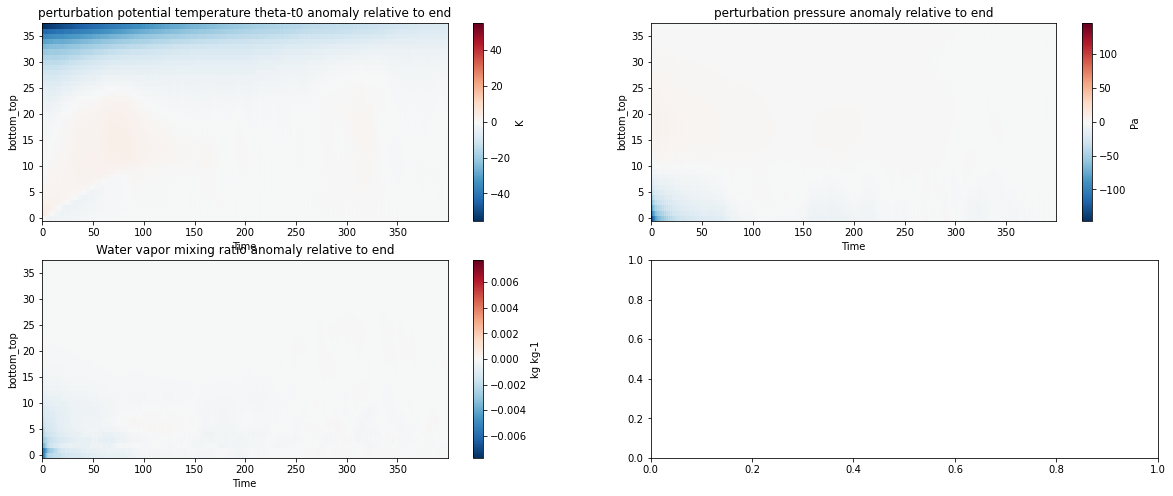

In [58]:
fig, ax = plt.subplots(2,2,figsize=(20,8))
ax=ax.reshape(-1)
plot_diff_levtime(Acontwrf,"T",ax[0])
plot_diff_levtime(Acontwrf,"P",ax[1])
plot_diff_levtime(Acontwrf,"QVAPOR",ax[2])



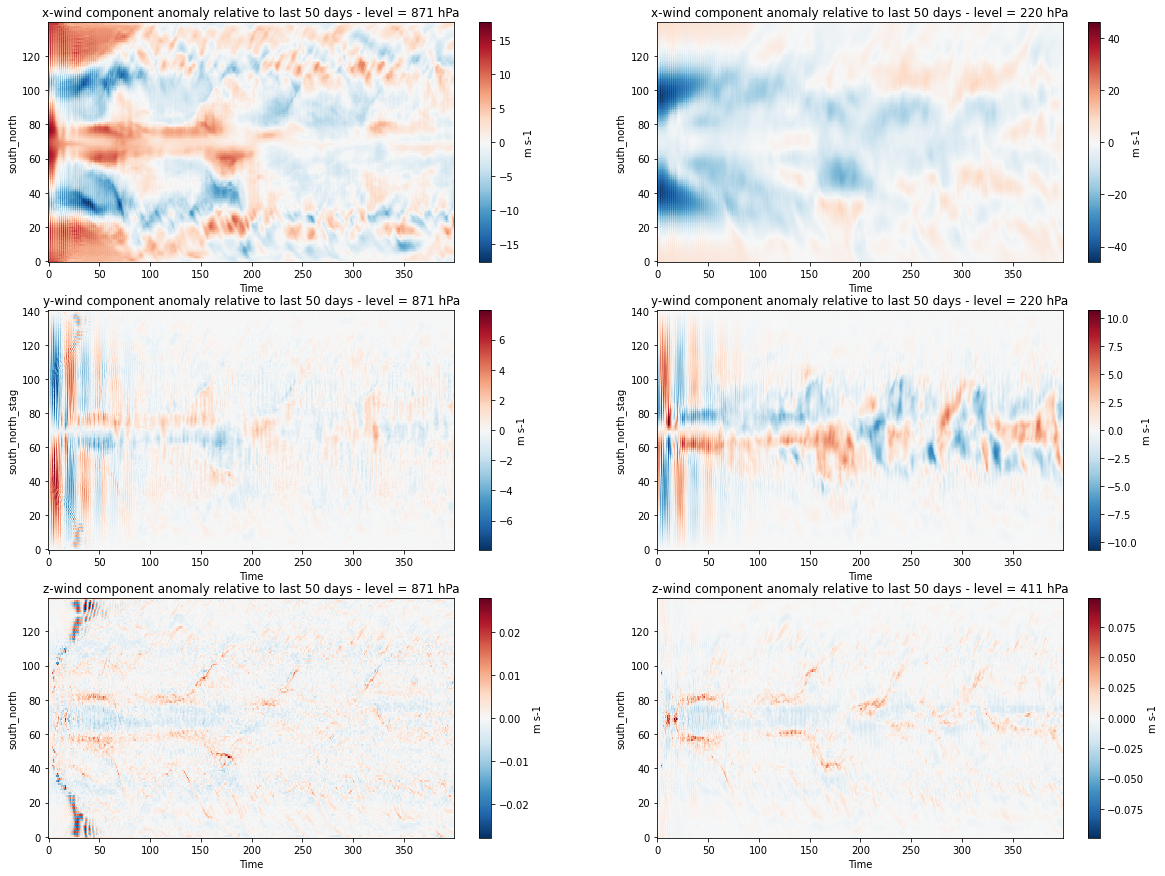

In [78]:
fig, ax = plt.subplots(3,2,figsize=(20,15))
ax=ax.reshape(-1)
plot_diff_lattime_3d(Acontwrf,"U",2,ax[0])
plot_diff_lattime_3d(Acontwrf,"U",25,ax[1])
plot_diff_lattime_3d(Acontwrf,"V",2,ax[2])
plot_diff_lattime_3d(Acontwrf,"V",25,ax[3])
plot_diff_lattime_3d(Acontwrf,"W",2,ax[4])
plot_diff_lattime_3d(Acontwrf,"W",15,ax[5])

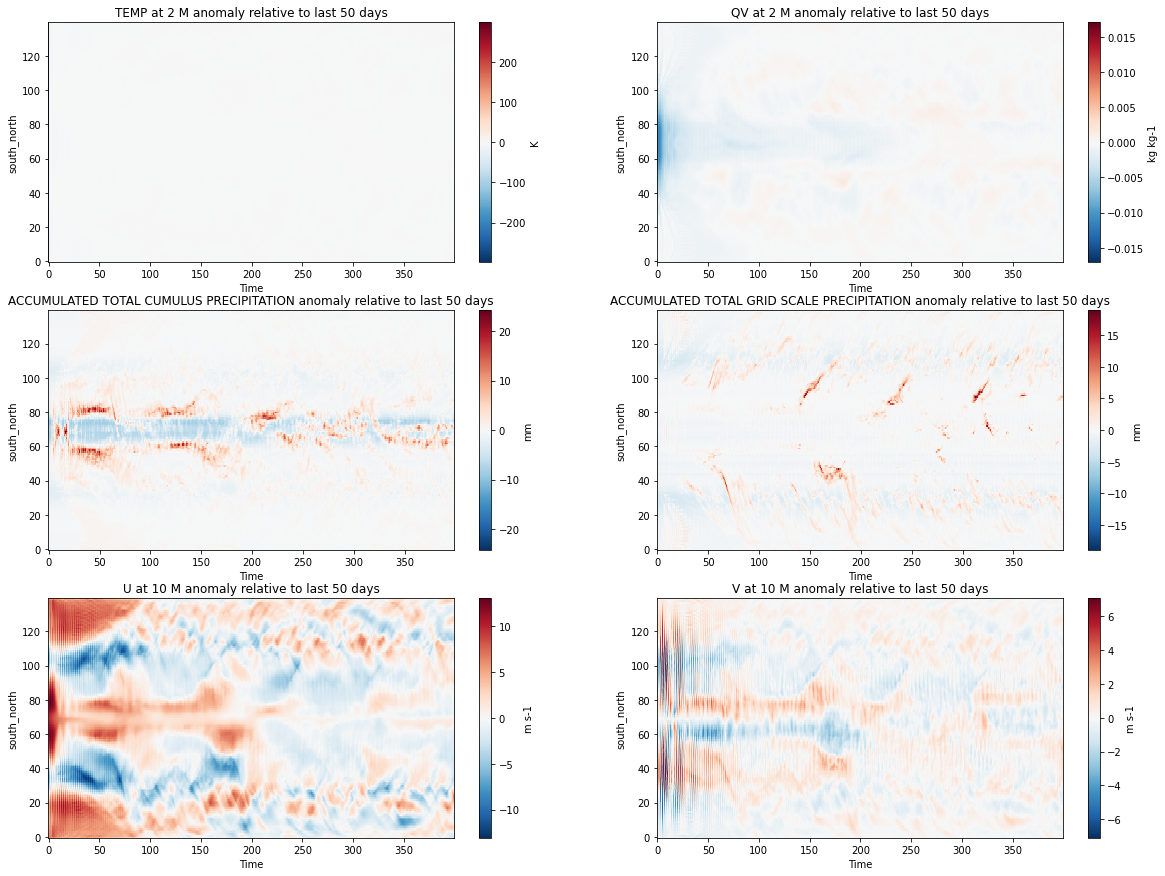

In [110]:
fig, ax = plt.subplots(3,2,figsize=(20,15))
ax=ax.reshape(-1)
plot_diff_lattime_2d(Acontwrf,"T2",ax[0])
plot_diff_lattime_2d(Acontwrf,"Q2",ax[1])
plot_diff_lattime_2d_rain(Acontwrf,"RAINC",ax[2])
plot_diff_lattime_2d_rain(Acontwrf,"RAINNC",ax[3])
plot_diff_lattime_2d(Acontwrf,"U10",ax[4])
plot_diff_lattime_2d(Acontwrf,"V10",ax[5])

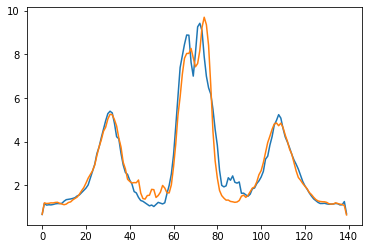

In [189]:
plt.plot(Acontwrf.south_north,4*(Acontwrf.RAINC+Acontwrf.RAINNC).isel(Time=slice(200,400)).diff('Time').mean(["Time","west_east"]).persist())
plt.plot(Acontwrf.south_north,4*(Acontwrf.RAINC+Acontwrf.RAINNC).isel(Time=slice(-200,-1)).diff('Time').mean(["Time","west_east"]).persist())



# Initial & Final profiles

## Temperature

0.01713705062866211
0.07268619537353516
300.141
0.01613330841064453
0.07453751564025879
299.00803
0.013713359832763672
0.06979012489318848
282.11508
0.013144969940185547
0.06906628608703613
273.15


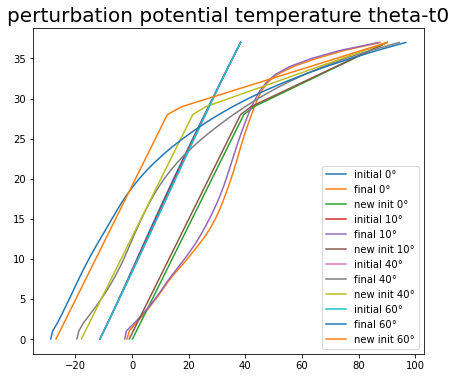

In [151]:
var="T"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)

for sn in [70,80,110,130]:
    t=time.time()
    ax.plot(Acontwrf[var].isel(Time=0).sel(south_north = sn,west_east=10).persist(),Acontwrf.bottom_top,label='initial %i°'%(sn-70))
    print(time.time()-t)
    ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='final %i°'%(sn-70))
    print(time.time()-t)
    sst = Acontwrf.SST.isel(Time=0).sel(south_north = sn,west_east=10)
    print(np.array(sst))
    breakpoint = 3*len(Acontwrf.bottom_top)/4
    newt = sst+40/breakpoint*np.minimum(Acontwrf.bottom_top,breakpoint)+(50+(300-sst))/(len(Acontwrf.bottom_top)-breakpoint-1)*np.maximum(Acontwrf.bottom_top-breakpoint,0.)
    t0 = 300
    ax.plot(newt-t0,Acontwrf.bottom_top,label='new init %i°'%(sn-70))

ax.legend()

0.02446293830871582
0.091766357421875
300.141
0.013779640197753906
0.07798123359680176
299.00803
0.2583169937133789
46.84751081466675
282.11508
0.16159272193908691
18.78160786628723
273.15


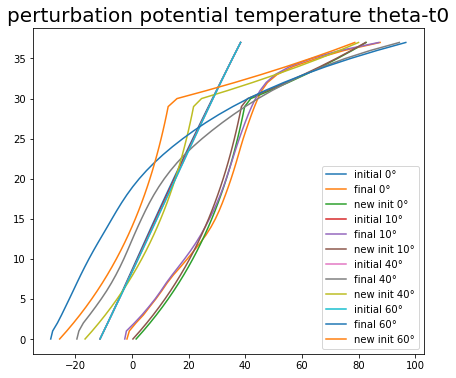

In [214]:
var="T"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)

for sn in [70,80,110,130]:
    t=time.time()
    ax.plot(Acontwrf[var].isel(Time=0).sel(south_north = sn,west_east=10).persist(),Acontwrf.bottom_top,label='initial %i°'%(sn-70))
    print(time.time()-t)
    ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='final %i°'%(sn-70))
    print(time.time()-t)
    sst = Acontwrf.SST.isel(Time=0).sel(south_north = sn,west_east=10)
    print(np.array(sst))
    pb=Acontwrf.PB.isel(Time=0,west_east=10).sel(south_north=sn).persist()
    breakpoint = 16000.
    ptop=8000
    newt = sst+40*(100000-np.maximum(pb,breakpoint))/(100000-breakpoint) +(50+(300-sst))*((breakpoint-pb)/(breakpoint-ptop))*(pb<=breakpoint)
    #*np.minimum(Acontwrf.bottom_top,breakpoint)+(50+(300-sst))/(len(Acontwrf.bottom_top)-breakpoint-1)*np.maximum(Acontwrf.bottom_top-breakpoint,0.)
    t0 = 300
    ax.plot(newt-t0,Acontwrf.bottom_top,label='new init %i°'%(sn-70))

ax.legend()

## Moisture

0.0174713134765625
0.09033536911010742
0.015169143676757812
0.08075165748596191
0.016515493392944336
0.08385038375854492
0.015244483947753906
0.0782632827758789


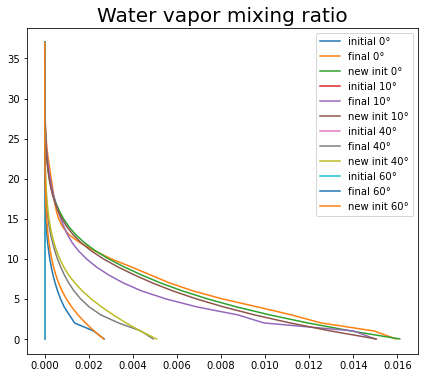

In [152]:
var="QVAPOR"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)
pb=Acontwrf.PB.isel(Time=0).isel(south_north=slice(69-40,70+40)).mean(['south_north','west_east']).persist()

for sn in [70,80,110,130]:
    t=time.time()
    ax.plot(Acontwrf[var].isel(Time=0).sel(south_north = sn,west_east=10).persist(),Acontwrf.bottom_top,label='initial %i°'%(sn-70))
    print(time.time()-t)
    ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='final %i°'%(sn-70))
    print(time.time()-t)
    sst = Acontwrf.SST.isel(Time=0).sel(south_north = sn,west_east=10)
    breakpoint = 3*len(Acontwrf.bottom_top)/4
    newt = sst+40/breakpoint*np.minimum(Acontwrf.bottom_top,breakpoint)+(50+(300-sst))/(len(Acontwrf.bottom_top)-breakpoint-1)*np.maximum(Acontwrf.bottom_top-breakpoint,0.)
    temperature = (pb/100000.)**0.286 * newt
    #print(temperature)
    ax.plot(0.8*qsat(temperature,pb/100),Acontwrf.bottom_top,label='new init %i°'%(sn-70))

ax.legend()

## Winds

CPU times: user 53.5 ms, sys: 43.9 ms, total: 97.5 ms
Wall time: 93.6 ms
CPU times: user 40.3 ms, sys: 307 ms, total: 348 ms
Wall time: 2.14 s
CPU times: user 28.7 ms, sys: 9.34 ms, total: 38.1 ms
Wall time: 33.3 ms


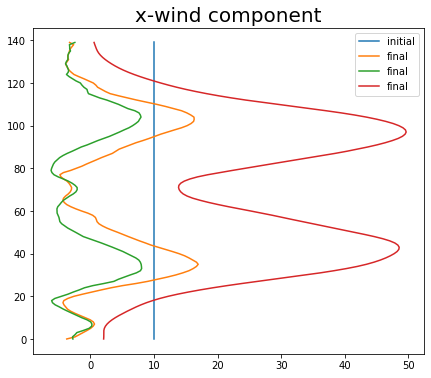

In [160]:
var="U"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)

ax.plot(Acontwrf[var].isel(Time=0).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean('bottom_top').persist(),Acontwrf.south_north,label='initial')
%time ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='final')
%time ax.plot(Acontwrf["U10"].isel(Time=slice(-200,-1)).sel(west_east=10).mean(['Time']).persist(),Acontwrf.south_north,label='final')
%time ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(west_east_stag=10).isel(bottom_top=25).mean(['Time']).persist(),Acontwrf.south_north,label='final')


ax.legend()

CPU times: user 38.3 ms, sys: 1.22 s, total: 1.25 s
Wall time: 3.68 s


ValueError: x and y must have same first dimension, but have shapes (140,) and (141,)

CPU times: user 43.8 ms, sys: 424 ms, total: 468 ms
Wall time: 2.7 s


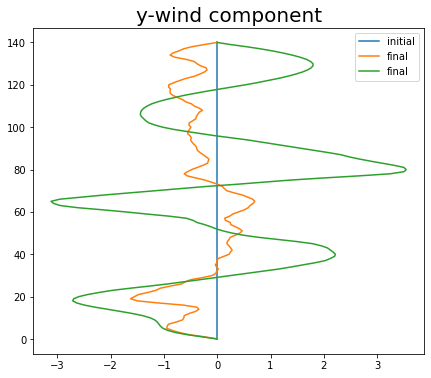

In [219]:
var="V"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)

ax.plot(Acontwrf[var].isel(Time=0).sel(west_east=10).isel(bottom_top=slice(0,10)).mean('bottom_top').persist(),Acontwrf.south_north_stag,label='initial')
%time ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(west_east=10).isel(bottom_top=slice(0,10)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north_stag,label='final')
%time ax.plot(Acontwrf["V10"].isel(Time=slice(-200,-1)).sel(west_east=10).mean(['Time']).persist(),Acontwrf.south_north_stag,label='final')
%time ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(west_east=10).isel(bottom_top=25).mean(['Time']).persist(),Acontwrf.south_north_stag,label='final')


ax.legend()

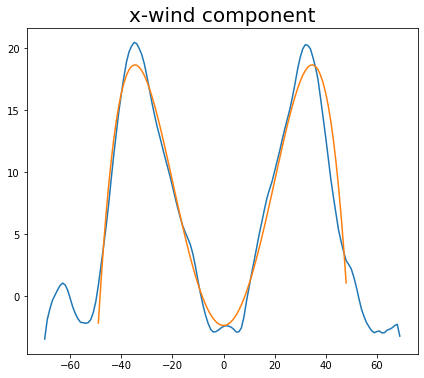

In [222]:
var='U'
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)
lats = np.array(Acontwrf.south_north)-70
winds = np.array(Acontwrf[var].isel(Time=slice(-200,-1)).sel(west_east_stag=10).isel(bottom_top=slice(0,15)).mean(['bottom_top','Time']))
lats2 = lats[20:-20]
p = np.polyfit(lats2, winds[20:-20], 4)
p=np.array([-1.45e-5,0.,3.49e-2,0.,-2.34])
fit = np.sum(p[::-1]*(np.ones(5)*lats2[:,None])**range(5),axis=1)
ax.plot(lats,winds)
ax.plot(lats2[1:-1],fit[1:-1])




# With new initialization

In [229]:
%%time
Anewiwrf = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/newinit.wrf.crosseq.aquaplanet.100km.100d/",nfiles=10)


CPU times: user 2.64 s, sys: 1.05 s, total: 3.7 s
Wall time: 2.8 s


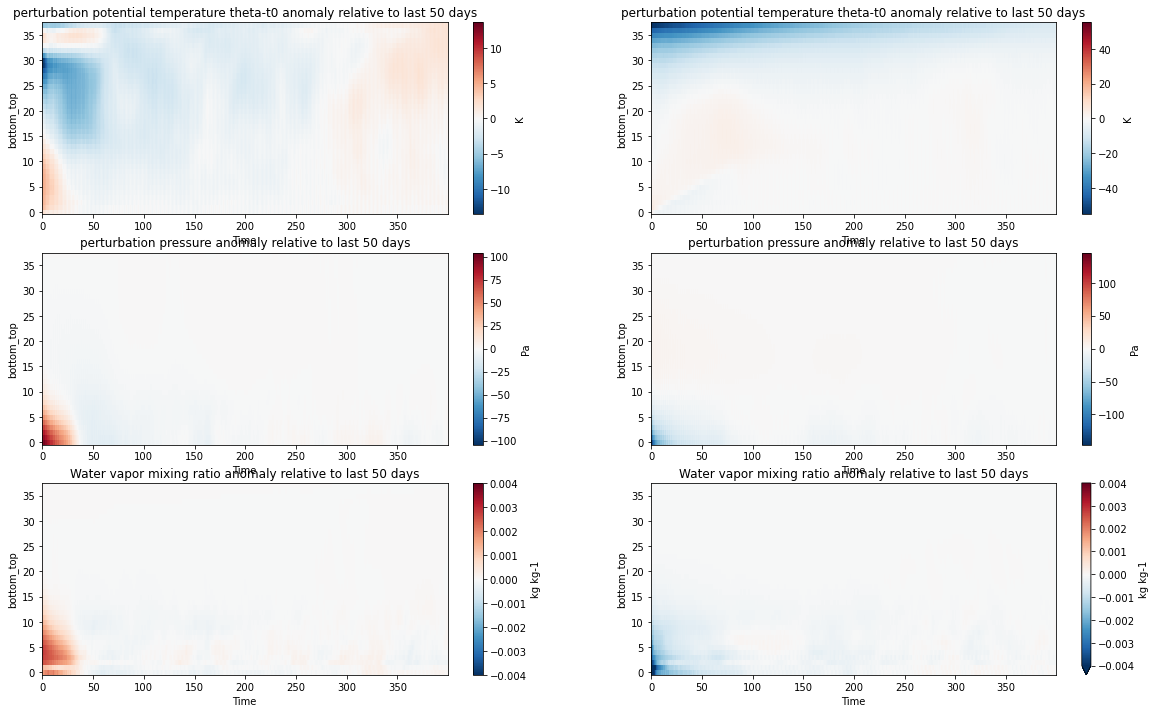

In [245]:
fig, ax = plt.subplots(3,2,figsize=(20,12))

plot_diff_levtime(Anewiwrf,"T",ax[0][0])
plot_diff_levtime(Acontwrf,"T",ax[0][1])
plot_diff_levtime(Anewiwrf,"P",ax[1][0])
plot_diff_levtime(Acontwrf,"P",ax[1][1])
plot_diff_levtime(Anewiwrf,"QVAPOR",ax[2][0],scale=0.004)
plot_diff_levtime(Acontwrf,"QVAPOR",ax[2][1],scale=0.004)



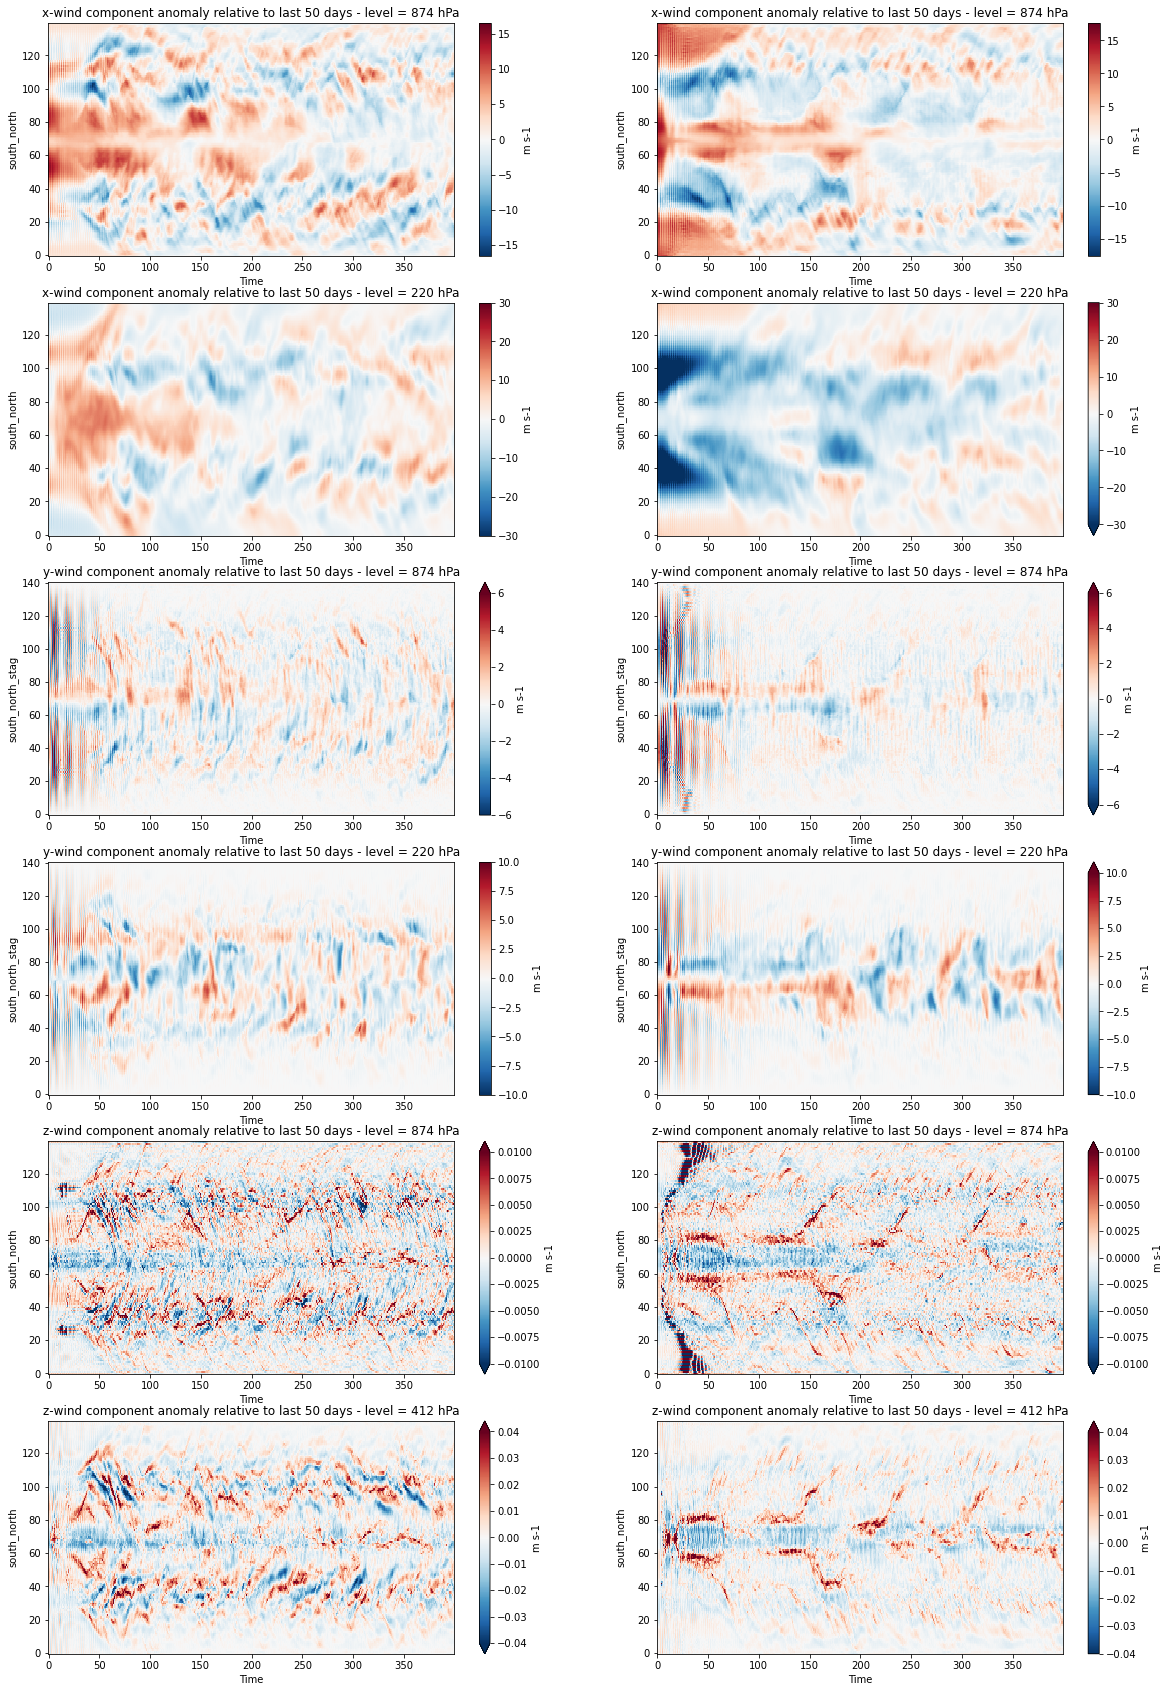

In [242]:
fig, ax = plt.subplots(6,2,figsize=(20,30))
plot_diff_lattime_3d(Anewiwrf,"U",2, ax[0][0])
plot_diff_lattime_3d(Acontwrf,"U",2, ax[0][1])
plot_diff_lattime_3d(Anewiwrf,"U",25,ax[1][0],scale=30)
plot_diff_lattime_3d(Acontwrf,"U",25,ax[1][1],scale=30)
plot_diff_lattime_3d(Anewiwrf,"V",2, ax[2][0],scale=6)
plot_diff_lattime_3d(Acontwrf,"V",2, ax[2][1],scale=6)
plot_diff_lattime_3d(Anewiwrf,"V",25,ax[3][0],scale=10)
plot_diff_lattime_3d(Acontwrf,"V",25,ax[3][1],scale=10)
plot_diff_lattime_3d(Anewiwrf,"W",2, ax[4][0],scale=0.01)
plot_diff_lattime_3d(Acontwrf,"W",2, ax[4][1],scale=0.01)
plot_diff_lattime_3d(Anewiwrf,"W",15,ax[5][0],scale=0.04)
plot_diff_lattime_3d(Acontwrf,"W",15,ax[5][1],scale=0.04)

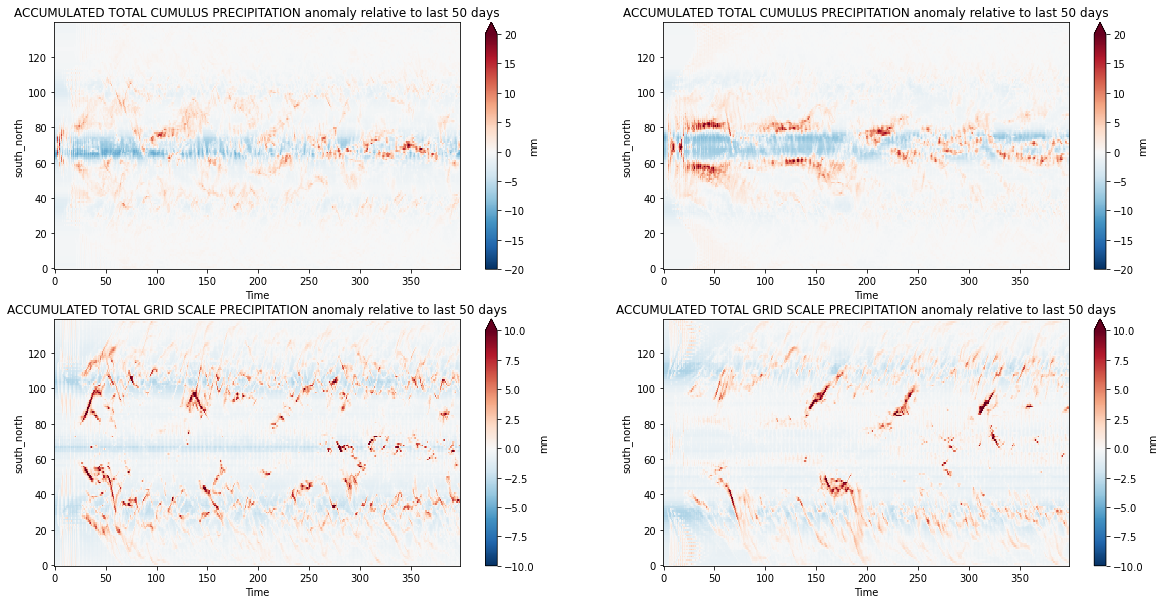

In [261]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
plot_diff_lattime_2d_rain(Anewiwrf,"RAINC", ax[0][0],scale=20)
plot_diff_lattime_2d_rain(Acontwrf,"RAINC", ax[0][1],scale=20)
plot_diff_lattime_2d_rain(Anewiwrf,"RAINNC",ax[1][0],scale=10)
plot_diff_lattime_2d_rain(Acontwrf,"RAINNC",ax[1][1],scale=10)


# Comparing final profiles in both simulations

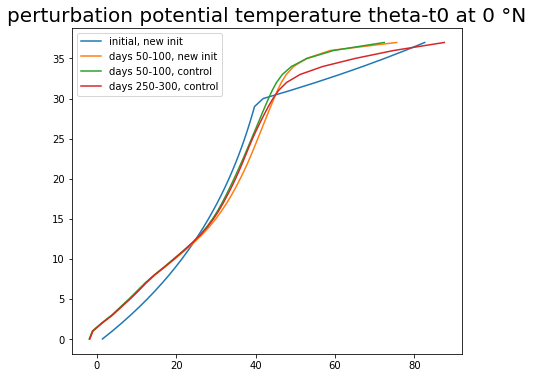

In [249]:
var="T"
sn=70
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description + " at %i °N"%(sn-70),fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).sel(south_north = sn).mean(['west_east']).persist(),Acontwrf.bottom_top,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 250-300, control')

ax.legend()


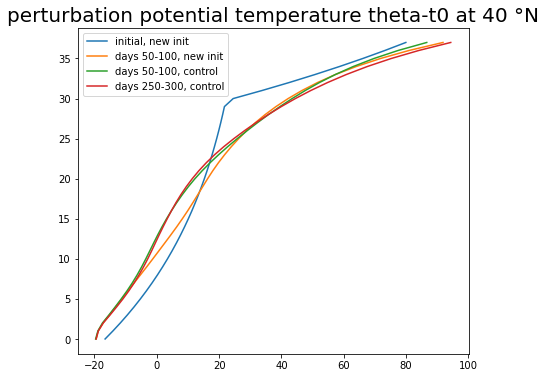

In [250]:
var="T"
sn=110
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description + " at %i °N"%(sn-70),fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).sel(south_north = sn).mean(['west_east']).persist(),Acontwrf.bottom_top,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 250-300, control')

ax.legend()


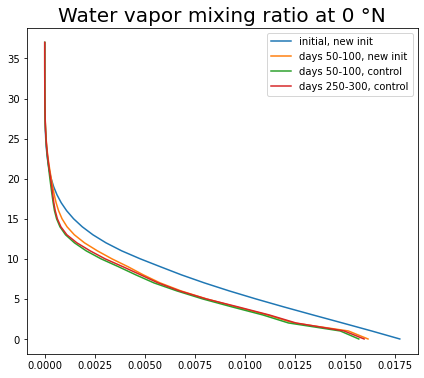

In [260]:
var="QVAPOR"
sn=70
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description + " at %i °N"%(sn-70),fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).sel(south_north = sn).mean(['west_east']).persist(),Acontwrf.bottom_top,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 250-300, control')

ax.legend()


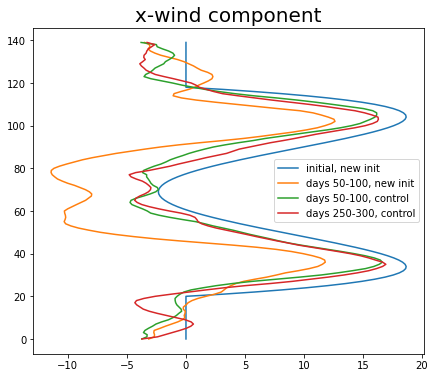

In [262]:
var="U"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top']).persist(),Acontwrf.south_north,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 250-300, control')


ax.legend()

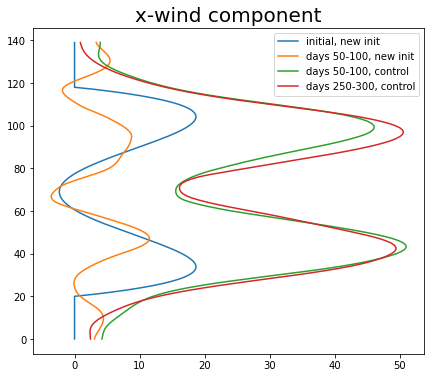

In [263]:
var="U"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top']).persist(),Acontwrf.south_north,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).sel(west_east_stag=10).isel(bottom_top=slice(25,30)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).sel(west_east_stag=10).isel(bottom_top=slice(25,30)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(west_east_stag=10).isel(bottom_top=slice(25,30)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 250-300, control')


ax.legend()

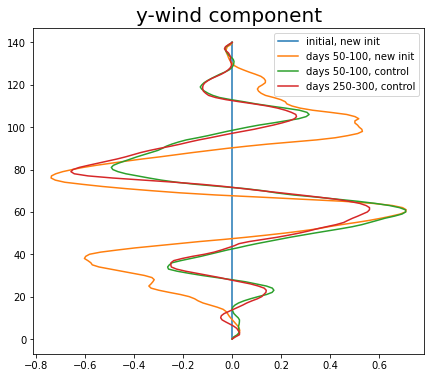

In [265]:
var="V"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).isel(bottom_top=slice(0,10)).mean(['west_east','bottom_top']).persist(),Acontwrf.south_north_stag,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).isel(bottom_top=slice(0,10)).mean(['west_east','bottom_top','Time']).persist(),Acontwrf.south_north_stag,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).isel(bottom_top=slice(0,10)).mean(['west_east','bottom_top','Time']).persist(),Acontwrf.south_north_stag,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).isel(bottom_top=slice(0,10)).mean(['west_east','bottom_top','Time']).persist(),Acontwrf.south_north_stag,label='days 250-300, control')


ax.legend()

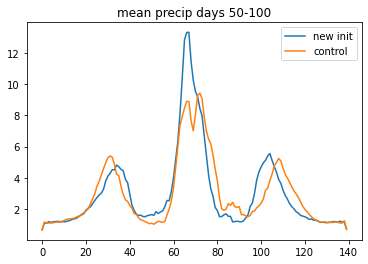

In [266]:
plt.plot(Anewiwrf.south_north,4*(Anewiwrf.RAINC+Anewiwrf.RAINNC).isel(Time=slice(200,400)).diff('Time').mean(["Time","west_east"]).persist(),label="new init")
plt.plot(Acontwrf.south_north,4*(Acontwrf.RAINC+Acontwrf.RAINNC).isel(Time=slice(200,400)).diff('Time').mean(["Time","west_east"]).persist(),label="control")
plt.title('mean precip days 50-100')
plt.legend()


# Generating input soundings

In [272]:
Acontwrf

<xarray.Dataset>
Dimensions:               (Time: 1200, bottom_top: 38, bottom_top_stag: 39, snow_layers_stag: 3, snso_layers_stag: 7, south_north: 140, south_north_stag: 141, west_east: 80, west_east_stag: 81)
Coordinates:
    XLAT                  (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    XLONG                 (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    XTIME                 (Time) datetime64[ns] dask.array<chunksize=(40,), meta=np.ndarray>
    XLAT_U                (Time, south_north, west_east_stag) float32 dask.array<chunksize=(40, 140, 81), meta=np.ndarray>
    XLONG_U               (Time, south_north, west_east_stag) float32 dask.array<chunksize=(40, 140, 81), meta=np.ndarray>
    XLAT_V                (Time, south_north_stag, west_east) float32 dask.array<chunksize=(40, 141, 80), meta=np.ndarray>
    XLONG_V               (Time, south_north_stag, west_east) float32 dask.array<chunksize=(40, 141, 80), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, snow_layers_stag, snso_layers_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times                 (Time) |S19 dask.array<chunksize=(40,), meta=np.ndarray>
    LU_INDEX              (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    ZNU                   (Time, bottom_top) float32 dask.array<chunksize=(40, 38), meta=np.ndarray>
    ZNW                   (Time, bottom_top_stag) float32 dask.array<chunksize=(40, 39), meta=np.ndarray>
    U                     (Time, bottom_top, south_north, west_east_stag) float32 dask.array<chunksize=(40, 38, 140, 81), meta=np.ndarray>
    V                     (Time, bottom_top, south_north_stag, west_east) float32 dask.array<chunksize=(40, 38, 141, 80), meta=np.ndarray>
    W                     (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(40, 39, 140, 80), meta=np.ndarray>
    PH                    (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(40, 39, 140, 80), meta=np.ndarray>
    PHB                   (Time, bottom_top_stag, south_north, west_east) float32 dask.array<chunksize=(40, 39, 140, 80), meta=np.ndarray>
    T                     (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    THM                   (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    MU                    (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    MUB                   (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    P                     (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    PB                    (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    RHO                   (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    THIS_IS_AN_IDEAL_RUN  (Time) int32 dask.array<chunksize=(40,), meta=np.ndarray>
    P_HYD                 (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(40, 38, 140, 80), meta=np.ndarray>
    Q2                    (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    T2                    (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    TH2                   (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    PSFC                  (Time, south_north, west_east) float32 dask.array<chunksize=(40, 140, 80), meta=np.ndarray>
    U10                   (Time, south_north, west_east) float32 dask.array<chun

In [339]:
intervals=[0.,10.,30.,50.,70.]
geopotentials=[]

phb_ztmean = Acontwrf.PHB.isel(Time=slice(-200,-1)).mean(['west_east','Time']).persist()
ph_ztmean = Acontwrf.PH.isel(Time=slice(-200,-1)).mean(['west_east','Time']).persist()
for i in range(len(intervals)-1):
    gheight = (phb_ztmean.sel(south_north = ((np.abs(var_ztmean.south_north-70) < intervals[i+1])&(np.abs(var_ztmean.south_north-70) >= intervals[i]))).mean('south_north')
                         +ph_ztmean.sel(south_north = ((np.abs(var_ztmean.south_north-70) < intervals[i+1])&(np.abs(var_ztmean.south_north-70) >= intervals[i]))).mean('south_north')
                         )/9.81
    geopotentials.append((gheight[1:]+gheight[:-1])/2.)
    
    


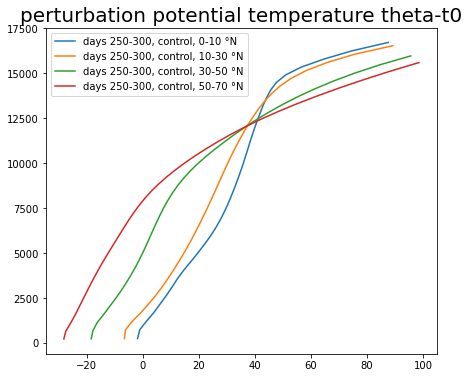

In [340]:
var="T"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)
var_ztmean = Acontwrf[var].isel(Time=slice(-200,-1)).mean(['west_east','Time']).persist()

temps=[]

for i in range(len(intervals)-1):
    temp=var_ztmean.sel(south_north = ((np.abs(var_ztmean.south_north-70) < intervals[i+1])&(np.abs(var_ztmean.south_north-70) >= intervals[i]))).mean('south_north')
    temps.append(temp)
    ax.plot(temp,geopotentials[i],label='days 250-300, control, %i-%i °N'%(intervals[i],intervals[i+1]))

ax.legend()

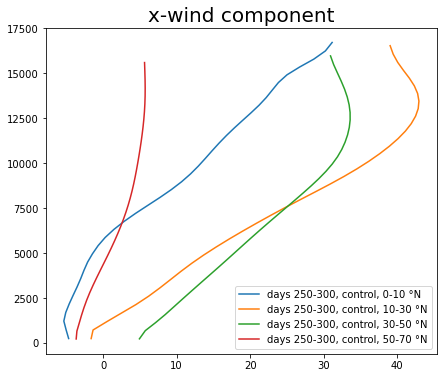

In [304]:
var="U"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)
var_ztmean = Acontwrf[var].isel(Time=slice(-200,-1)).mean(['west_east_stag','Time']).persist()

us=[]

for i in range(len(intervals)-1):
    temp=var_ztmean.sel(south_north = ((np.abs(var_ztmean.south_north-70) < intervals[i+1])&(np.abs(var_ztmean.south_north-70) >= intervals[i]))).mean('south_north')
    us.append(temp)
    ax.plot(temp,geopotentials[i],label='days 250-300, control, %i-%i °N'%(intervals[i],intervals[i+1]))

ax.legend()

In [305]:
SCRATCH='/global/cscratch1/sd/qnicolas/'
for i in range(len(intervals)-1):
    f = open(SCRATCH+'WRF/WRFV4_aq_crosseq/test/em_beta_plane/input_sounding{:02d}'.format(i+1), "w")
    print('{:10.2f}{:10.2f}{:10.2f}'.format(80.,300+np.interp(16000.,geopotentials[i],temps[i]),0.),file=f)
    for hgt in np.arange(0.,16001.,50.):
        print('{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}'.format(hgt,300+np.interp(hgt,geopotentials[i],temps[i]),0.,np.interp(hgt,geopotentials[i],us[i]),0.),file=f)
    f.close()

In [342]:
i=0
f = open(SCRATCH+'WRF/WRFV4_aq_crosseq/test/em_beta_plane/input_sounding_beta_plane', "w")
print('{:10.2f}{:10.2f}{:10.2f}'.format(80.,300+np.interp(16000.,geopotentials[i],temps[i]),0.),file=f)
for hgt in np.arange(0.,16001.,50.):
    print('{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}'.format(hgt,300+np.interp(hgt,geopotentials[i],temps[i]),0.,10.,0.),file=f)
f.close()

# T(z) design

In [446]:
lats=[0,10,30,50,69]
geopotentials=[]

phb_ztmean = Acontwrf.PHB.isel(Time=slice(-200,-1)).mean(['west_east','Time']).persist()
ph_ztmean = Acontwrf.PH.isel(Time=slice(-200,-1)).mean(['west_east','Time']).persist()
for l in lats:
    gheight = (phb_ztmean.sel(south_north = l+70)
                         +ph_ztmean.sel(south_north = l+70)
                         )/9.81
    geopotentials.append((gheight[1:]+gheight[:-1])/2.)

300.141
299.00803
289.62836
275.66647
273.15


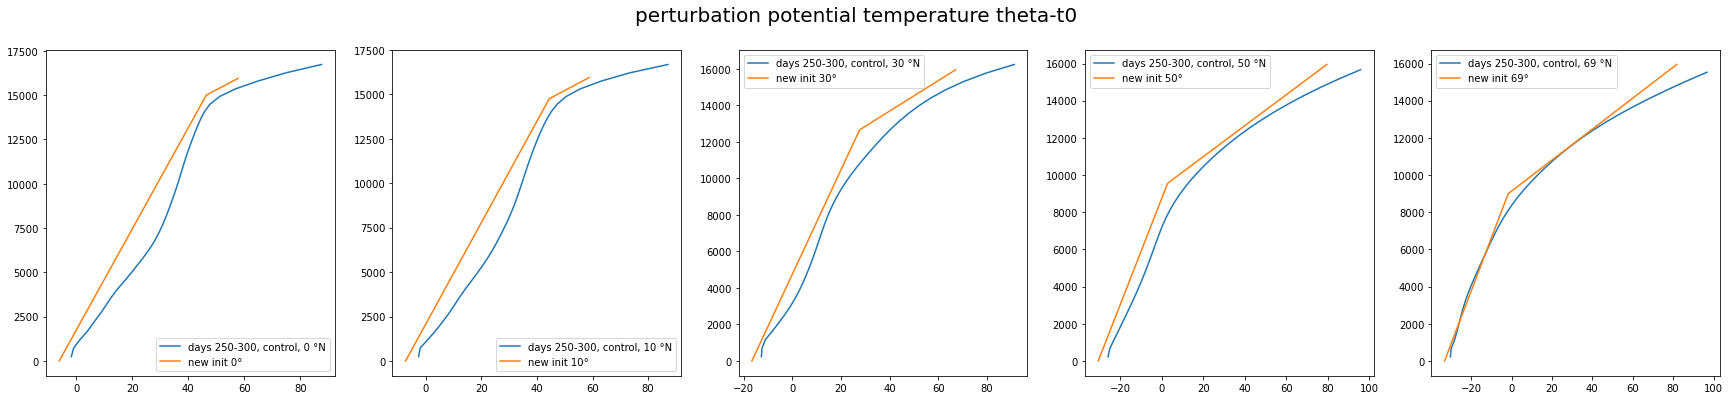

In [447]:
var="T"
fig, ax = plt.subplots(1,len(lats),figsize=(30,6))
fig.suptitle(Acontwrf[var].description,fontsize=20)
var_ztmean = Acontwrf[var].isel(Time=slice(-200,-1)).mean(['west_east','Time']).persist()

for i in range(len(lats)):
    sn=70+lats[i]
    temp=var_ztmean.sel(south_north = sn)
    ax[i].plot(temp,geopotentials[i],label='days 250-300, control, %i °N'%(lats[i]))
    
    sst = Acontwrf.SST.isel(Time=0).sel(south_north = sn,west_east=10)
    sst=np.array(sst.load())
    zs = np.arange(0.,16000.,50.)
    breakpoint = 9000 + 6000*(sst-273.15)/27#6000*(70-lats[i])/70
    print(sst)
    #newt = sst+40*(100000-np.maximum(pb,breakpoint))/(100000-breakpoint) +(50+(300-sst))*((breakpoint-pb)/(breakpoint-ptop))*(pb<=breakpoint)
    newt = sst+ np.minimum(zs,breakpoint)*3.5e-3 + (zs>breakpoint)*(zs-breakpoint)*12e-3 -6.28
    t0 = 300
    ax[i].plot(newt-t0,zs,label='new init %i°'%(sn-70))
    ax[i].legend()

In [484]:
r=287.
cp = 7/2*r
cv = cp-r
cvpm = -cv/cp
g=9.81

def compute_pressure(sst):  
    zs = np.arange(0.,16000.,50.)
    breakpoint = 9000 + 6000*(sst-273.15)/27#6000*(70-lats[i])/70
    newt = sst+ np.minimum(zs,breakpoint)*3.5e-3 + (zs>breakpoint)*(zs-breakpoint)*12e-3-6.67
    
    h_input=zs
    th_input=newt
    p_top = 8801.
    p1000mb = 100000.
    th_top = newt[-1]
    rho_top = 1./((r/p1000mb)*th_top*((p_top/p1000mb)**cvpm))

    rho_input = np.zeros(len(zs))
    pm_input  = np.zeros(len(zs))
    rho_input[-1] = rho_top
    pm_input[-1]  = p_top

    for k in range(len(zs)-2,-1,-1):
        rho_input[k] = rho_input[k+1]
        dz = h_input[k+1]-h_input[k]
        for _ in range(10):
            pm_input[k] = pm_input[k+1] + 0.5*dz*(rho_input[k]+rho_input[k+1])*g
            if (pm_input[k] < 0. ) :
                print("negative pressure")
            rho_input[k] = 1./((r/p1000mb)*th_input[k]*((pm_input[k]/p1000mb)**cvpm))
    print(len(pm_input),pm_input)
    return pm_input[0]


In [492]:
p=100000
for k in range(2,229+1):
    p-=400.
p

8800.0

In [491]:
len(np.arange(8800,100001,400))

229

In [485]:
compute_pressure(273.15)

320 [104253.39942825 103594.39334017 102938.7975608  102286.59758561
 101637.77896437 100992.32730086 100350.22825274  99711.46753128
  99076.03090121  98443.90418048  97815.07324006  97189.52400377
  96567.24244804  95948.21460173  95332.42654591  94719.86441371
  94110.51439005  93504.36271151  92901.3956661   92301.59959306
  91704.9608827   91111.46597615  90521.10136523  89933.85359222
  89349.70924966  88768.6549802   88190.67747637  87615.76348041
  87043.89978411  86475.07322855  85909.27070397  85346.4791496
  84786.6855534   84229.87695197  83676.04043028  83125.16312156
  82577.23220705  82032.23491589  81490.15852488  80950.99035834
  80414.71778791  79881.32823237  79350.8091575   78823.14807583
  78298.33254656  77776.35017529  77257.18861393  76740.83556046
  76227.27875879  75716.50599859  75208.5051151   74703.26398899
  74200.77054615  73701.01275756  73203.97863908  72709.65625134
  72218.0336995   71729.09913315  71242.84074612  70759.24677629
  70278.30550546  6980

104253.39942825088

In [483]:
compute_pressure(300.)

[94909.08073476 94349.13512297 93791.88484377 93237.31929881
 92685.42792604 92136.20019964 91589.62562987 91045.69376294
 90504.3941809  89965.7165015  89429.65037806 88896.18549938
 88365.31158959 87837.01840803 87311.29574912 86788.13344226
 86267.52135171 85749.44937644 85233.90745003 84720.88554055
 84210.37365043 83702.36181637 83196.84010917 82693.79863368
 82193.22752861 81695.11696647 81199.45715342 80706.23832918
 80215.45076688 79727.08477297 79241.13068713 78757.57888208
 78276.41976354 77797.64377008 77321.24137301 76847.20307628
 76375.51941637 75906.18096215 75439.1783148  74974.50210768
 74512.14300622 74052.09170784 73594.33894179 73138.87546909
 72685.69208238 72234.77960584 71786.12889507 71339.73083698
 70895.57634971 70453.65638247 70013.9619155  69576.48395989
 69141.21355754 68708.14178102 68277.25973349 67848.55854855
 67422.02939019 66997.66345266 66575.45196035 66155.38616774
 65737.45735923 65321.6568491  64907.97598136 64496.40612969
 64086.93869731 63679.56

94909.08073475686

In [403]:
ssts = np.array(Acontwrf.SST.isel(Time=0).sel(west_east=10))

In [467]:
np.mean(np.array([compute_pressure(sst) for sst in ssts]))

100003.91646330945

# With new initialization - 2

In [7]:
%%time
Anewiwrf = extract_wrfout("/global/cscratch1/sd/qnicolas/WRF/WRFV4_aq_crosseq/test/em_beta_plane/",nfiles=10)


CPU times: user 2.43 s, sys: 891 ms, total: 3.32 s
Wall time: 3.26 s


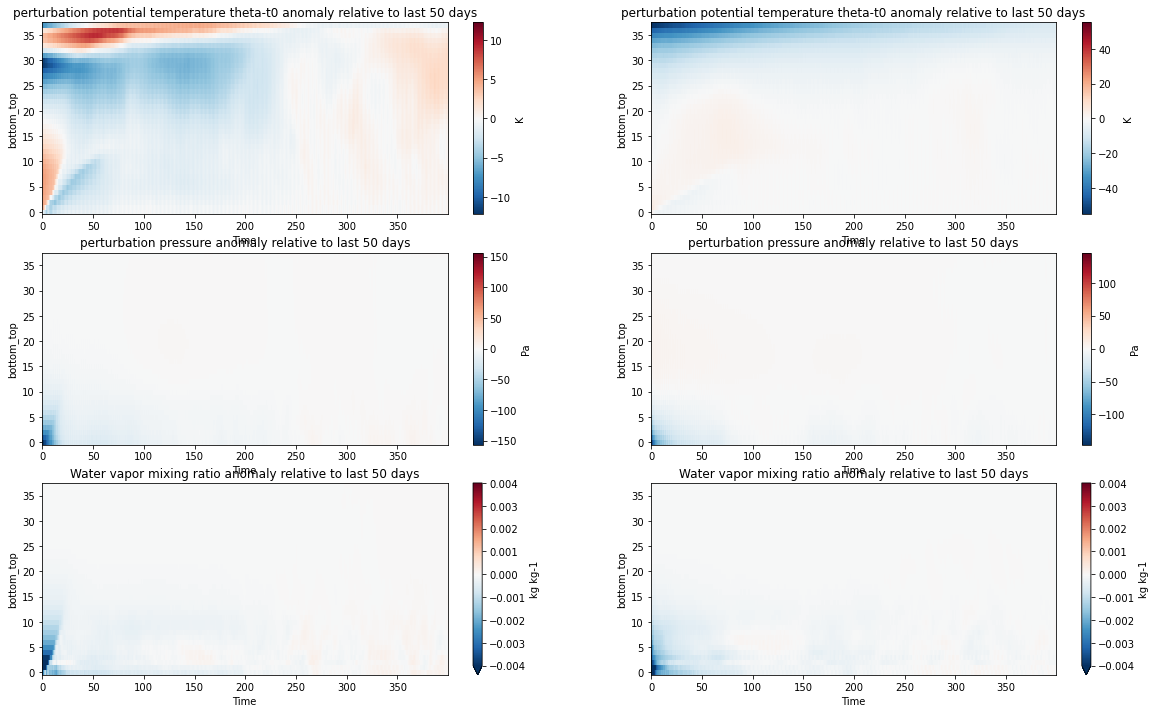

In [8]:
fig, ax = plt.subplots(3,2,figsize=(20,12))

plot_diff_levtime(Anewiwrf,"T",ax[0][0])
plot_diff_levtime(Acontwrf,"T",ax[0][1])
plot_diff_levtime(Anewiwrf,"P",ax[1][0])
plot_diff_levtime(Acontwrf,"P",ax[1][1])
plot_diff_levtime(Anewiwrf,"QVAPOR",ax[2][0],scale=0.004)
plot_diff_levtime(Acontwrf,"QVAPOR",ax[2][1],scale=0.004)



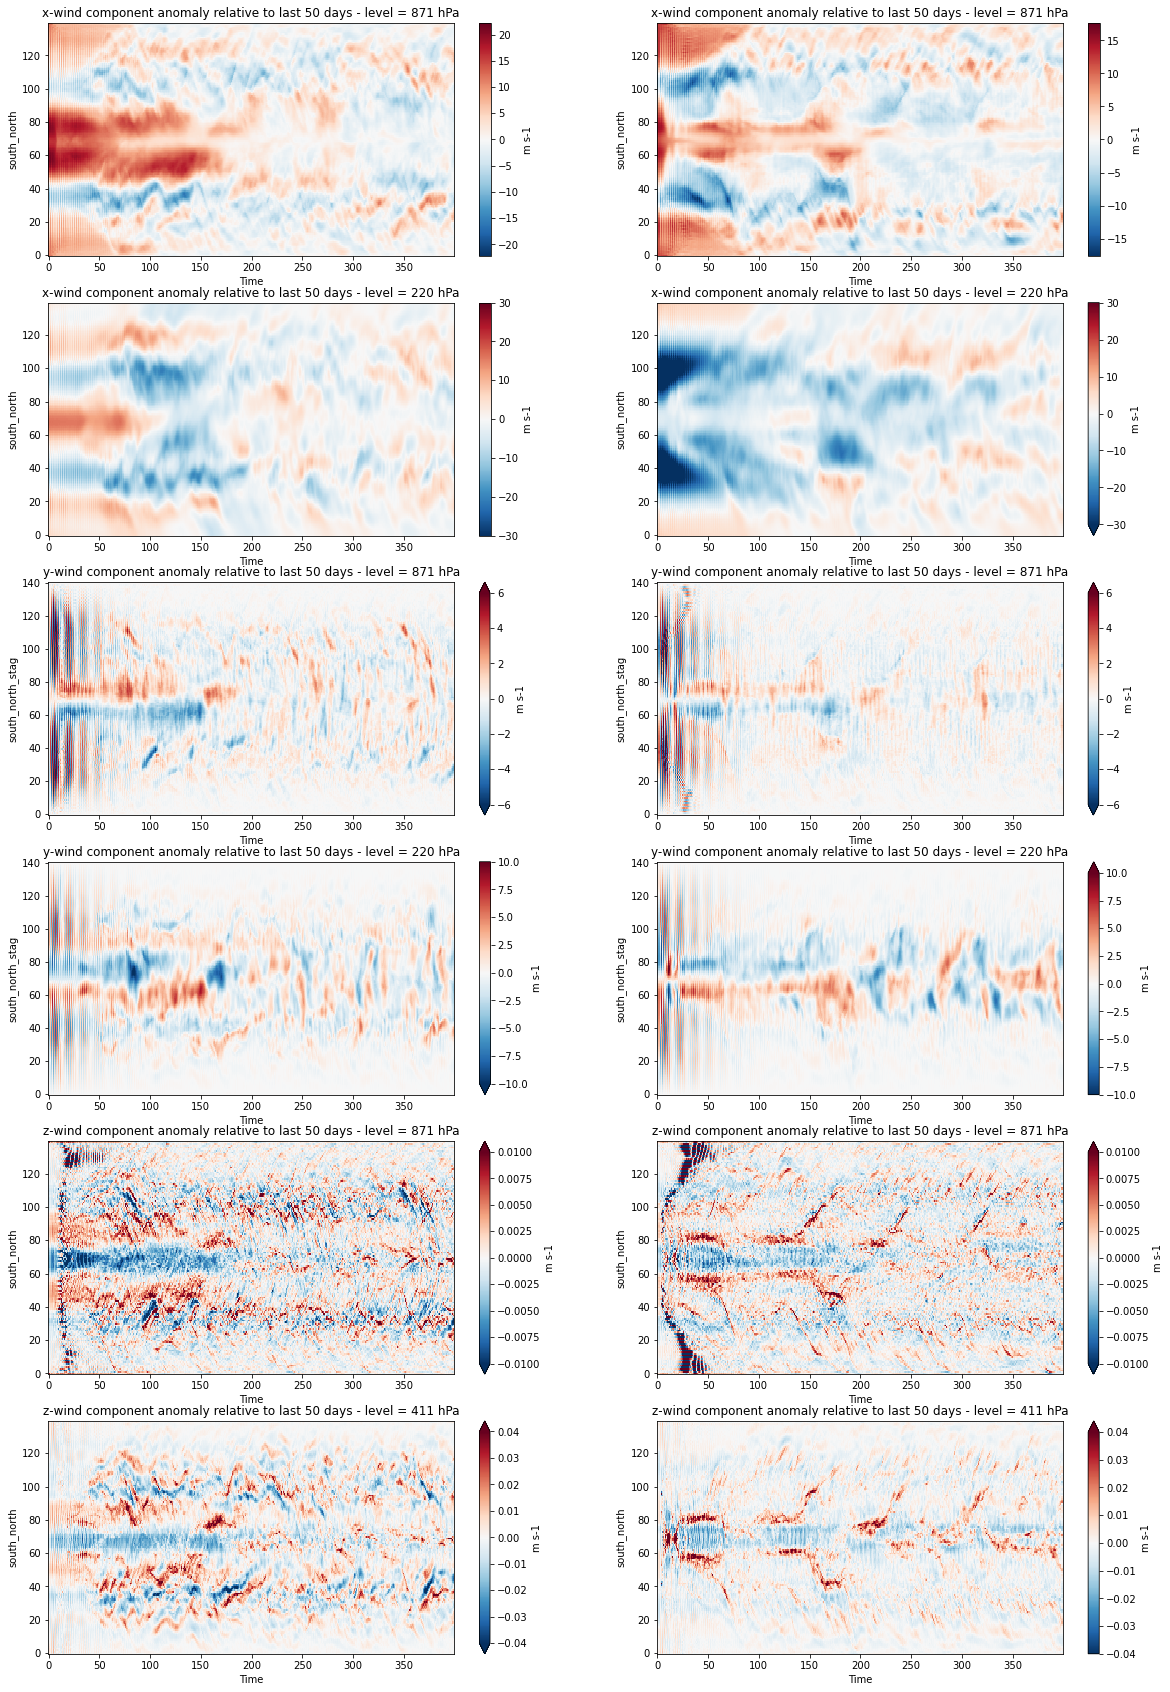

In [11]:
fig, ax = plt.subplots(6,2,figsize=(20,30))
plot_diff_lattime_3d(Anewiwrf,"U",2, ax[0][0])
plot_diff_lattime_3d(Acontwrf,"U",2, ax[0][1])
plot_diff_lattime_3d(Anewiwrf,"U",25,ax[1][0],scale=30)
plot_diff_lattime_3d(Acontwrf,"U",25,ax[1][1],scale=30)
plot_diff_lattime_3d(Anewiwrf,"V",2, ax[2][0],scale=6)
plot_diff_lattime_3d(Acontwrf,"V",2, ax[2][1],scale=6)
plot_diff_lattime_3d(Anewiwrf,"V",25,ax[3][0],scale=10)
plot_diff_lattime_3d(Acontwrf,"V",25,ax[3][1],scale=10)
plot_diff_lattime_3d(Anewiwrf,"W",2, ax[4][0],scale=0.01)
plot_diff_lattime_3d(Acontwrf,"W",2, ax[4][1],scale=0.01)
plot_diff_lattime_3d(Anewiwrf,"W",15,ax[5][0],scale=0.04)
plot_diff_lattime_3d(Acontwrf,"W",15,ax[5][1],scale=0.04)

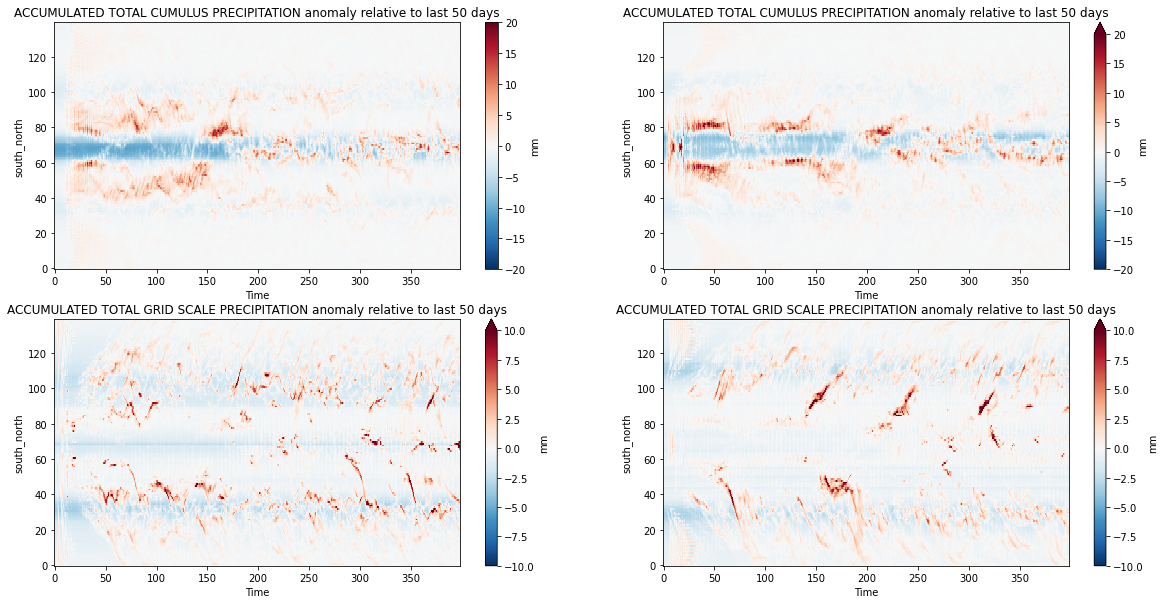

In [12]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
plot_diff_lattime_2d_rain(Anewiwrf,"RAINC", ax[0][0],scale=20)
plot_diff_lattime_2d_rain(Acontwrf,"RAINC", ax[0][1],scale=20)
plot_diff_lattime_2d_rain(Anewiwrf,"RAINNC",ax[1][0],scale=10)
plot_diff_lattime_2d_rain(Acontwrf,"RAINNC",ax[1][1],scale=10)


# Comparing final profiles in both simulations - 2

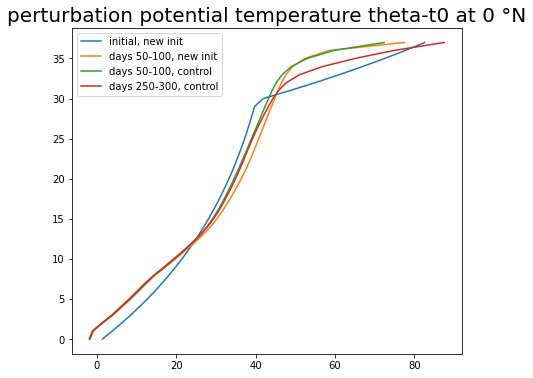

In [13]:
var="T"
sn=70
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description + " at %i °N"%(sn-70),fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).sel(south_north = sn).mean(['west_east']).persist(),Acontwrf.bottom_top,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 250-300, control')

ax.legend()


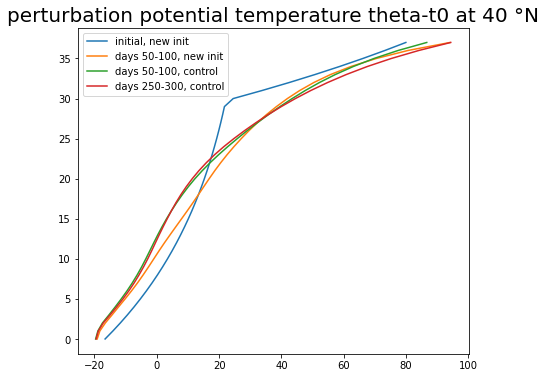

In [14]:
var="T"
sn=110
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description + " at %i °N"%(sn-70),fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).sel(south_north = sn).mean(['west_east']).persist(),Acontwrf.bottom_top,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 250-300, control')

ax.legend()


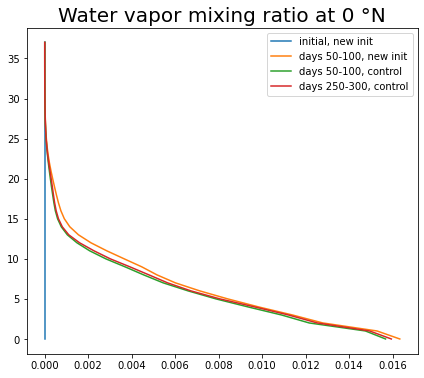

In [15]:
var="QVAPOR"
sn=70
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description + " at %i °N"%(sn-70),fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).sel(south_north = sn).mean(['west_east']).persist(),Acontwrf.bottom_top,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(south_north = sn).mean(['west_east','Time']).persist(),Acontwrf.bottom_top,label='days 250-300, control')

ax.legend()


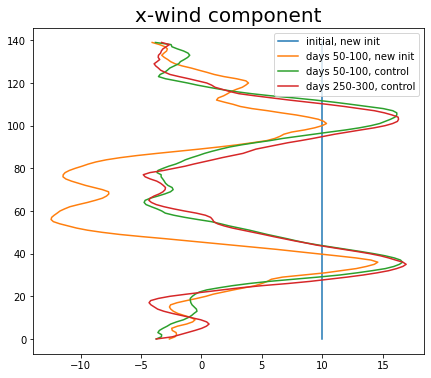

In [16]:
var="U"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top']).persist(),Acontwrf.south_north,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 250-300, control')


ax.legend()

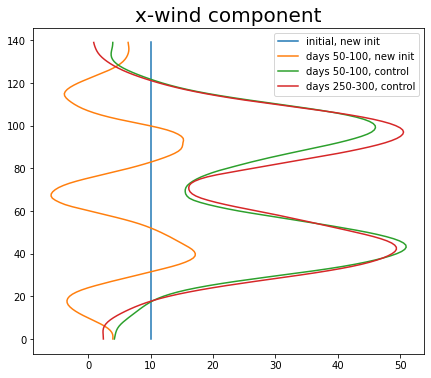

In [17]:
var="U"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).sel(west_east_stag=10).isel(bottom_top=slice(0,10)).mean(['bottom_top']).persist(),Acontwrf.south_north,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).sel(west_east_stag=10).isel(bottom_top=slice(25,30)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).sel(west_east_stag=10).isel(bottom_top=slice(25,30)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).sel(west_east_stag=10).isel(bottom_top=slice(25,30)).mean(['bottom_top','Time']).persist(),Acontwrf.south_north,label='days 250-300, control')


ax.legend()

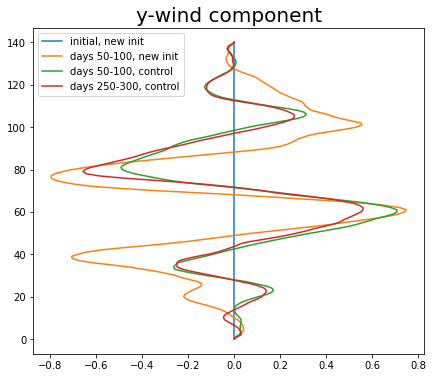

In [18]:
var="V"
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title(Acontwrf[var].description,fontsize=20)

ax.plot(Anewiwrf[var].isel(Time=0).isel(bottom_top=slice(0,10)).mean(['west_east','bottom_top']).persist(),Acontwrf.south_north_stag,label='initial, new init')
ax.plot(Anewiwrf[var].isel(Time=slice(200,400)).isel(bottom_top=slice(0,10)).mean(['west_east','bottom_top','Time']).persist(),Acontwrf.south_north_stag,label='days 50-100, new init')
ax.plot(Acontwrf[var].isel(Time=slice(200,400)).isel(bottom_top=slice(0,10)).mean(['west_east','bottom_top','Time']).persist(),Acontwrf.south_north_stag,label='days 50-100, control')
ax.plot(Acontwrf[var].isel(Time=slice(-200,-1)).isel(bottom_top=slice(0,10)).mean(['west_east','bottom_top','Time']).persist(),Acontwrf.south_north_stag,label='days 250-300, control')


ax.legend()

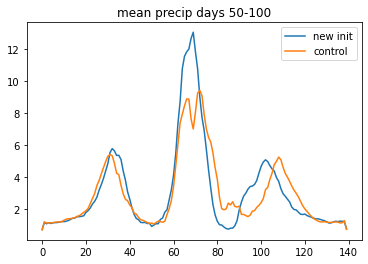

In [19]:
plt.plot(Anewiwrf.south_north,4*(Anewiwrf.RAINC+Anewiwrf.RAINNC).isel(Time=slice(200,400)).diff('Time').mean(["Time","west_east"]).persist(),label="new init")
plt.plot(Acontwrf.south_north,4*(Acontwrf.RAINC+Acontwrf.RAINNC).isel(Time=slice(200,400)).diff('Time').mean(["Time","west_east"]).persist(),label="control")
plt.title('mean precip days 50-100')
plt.legend()


In [20]:
def plot_2dvar(var):
    fig, ax = plt.subplots(1,1,figsize=(7,6))
    var.plot(ax=ax)
    #ax.set_title(var.description,fontsize=20)

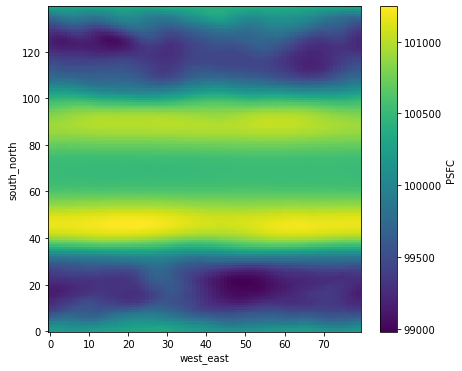

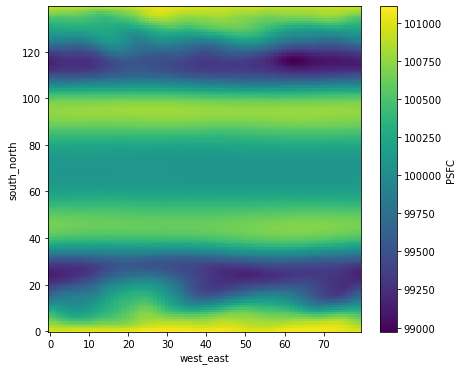

In [21]:
plot_2dvar(Anewiwrf.PSFC.isel(Time=slice(200,400)).mean(['Time']))
plot_2dvar(Acontwrf.PSFC.isel(Time=slice(200,400)).mean(['Time']))

In [25]:
Acontwrf.ACHFX.isel(Time=-1).mean().load()

<xarray.DataArray 'ACHFX' ()>
array(5.0311088e+08, dtype=float32)
Coordinates:
    XTIME    datetime64[ns] 1970-10-27T18:00:00

In [26]:
Acontwrf.ACLHF.isel(Time=-1).mean().load()

<xarray.DataArray 'ACLHF' ()>
array(2.27421e+09, dtype=float32)
Coordinates:
    XTIME    datetime64[ns] 1970-10-27T18:00:00

# shifting input sounding

In [20]:
f = open(SCRATCH+'WRF/WRFV4_aq_crosseq/test/em_beta_plane/input_sounding.backup', "r")
alllines=[]
l=[0]
while len(l)>0 :
    l=f.readline().split()
    alllines.append(l)
alllines = alllines[:-1]    

In [21]:
i=0
f = open(SCRATCH+'WRF/WRFV4_aq_crosseq/test/em_beta_plane/input_sounding', "w")
print('{:>10s}{:10.2f}{:>10s}'.format(alllines[0][0],float(alllines[0][1])-5.,alllines[0][2]),file=f)
for i,l in enumerate(alllines[1:]):
    print('{:>10s}{:10.2f}{:>10s}{:>10s}{:>10s}'.format(l[0],float(l[1])-5.,*l[2:]),file=f)
f.close()

In [13]:
print('{:10s}{:10s}{:10s}'.format(*alllines[0]))

1000.000  288.00    0.00      
